### Server bottleneck analysis

In [1]:
import re
import pandas as pd
import matplotlib.pyplot as plt

def analyze_cpu_for_targets(file_name, targets=("server", "load_generator")):

    # using patters for matching
    pattern = re.compile(
        r"^(\S+\s+\S+)\s+"            # timestamp (capture)
        r"(\d+)\s+"                   # UID
        r"(\d+)\s+"                   # PID
        r"([\d.]+)\s+"                # %usr
        r"([\d.]+)\s+"                # %system
        r"([\d.]+)\s+"                # %guest
        r"([\d.]+)\s+"                # %wait
        r"([\d.]+)\s+"                # %CPU
        r"(\d+)\s+"                   # CPU(core)
        r"(.+)$"                      # command
    )

    # Store raw samples for detailed analysis
    samples = {name: [] for name in targets}

    # Store aggregated statistics
    results = {
        name: {"usr": [], "sys": [], "wait": [], "cpu": [], "cores": []}
        for name in targets
    }

    with open(file_name) as f:
        for line in f:
            m = pattern.match(line.rstrip())
            if not m:
                continue

            timestamp = m.group(1)
            uid = int(m.group(2))
            pid = int(m.group(3))
            usr = float(m.group(4))
            sys = float(m.group(5))
            guest = float(m.group(6))
            wait = float(m.group(7))
            cpu = float(m.group(8))
            core = int(m.group(9))
            cmd = m.group(10).strip()

            for target in targets:
                if target in cmd:
                    # append sample
                    samples[target].append({
                        "timestamp": timestamp,
                        "uid": uid,
                        "pid": pid,
                        "usr": usr,
                        "sys": sys,
                        "guest": guest,
                        "wait": wait,
                        "cpu": cpu,
                        "core": core,
                        "cmd": cmd
                    })

                    # aggregated stats
                    r = results[target]
                    r["usr"].append(usr)
                    r["sys"].append(sys)
                    r["wait"].append(wait)
                    r["cpu"].append(cpu)
                    r["cores"].append(core)

    # add samples["load_generator"] here to view stats of load generator as well
    summary = pd.DataFrame(samples["server"])
    
    grouped = summary.groupby("cmd")

    df = grouped["cpu"].agg(["max", "mean", "median"])

    df["avg_usr"] = grouped["usr"].mean()
    df["avg_sys"] = grouped["sys"].mean()

    # print(df)
    return df


In [14]:
files = ["./cpu_2.log","./cpu_4.log","./cpu_6.log","./cpu_7.log","./cpu_8.log","./cpu_10.log","./cpu_12.log"]

summaries = []
for f in files:
    df = analyze_cpu_for_targets(f).copy()
    threads = int(re.search(r"cpu_(\d+)\.log", f).group(1))
    df["threads"] = threads
    summaries.append(df)

all_summaries = pd.concat(summaries).sort_values("threads")
print(all_summaries)


          max       mean  median    avg_usr    avg_sys  threads
cmd                                                            
server   82.0  73.723520    74.0  55.605279  18.118240        2
server   99.0  94.352737    95.0  70.497737  23.855000        4
server   99.0  96.022299    97.0  72.560360  23.461939        6
server  100.0  96.104349    97.0  72.670249  23.434072        7
server   99.0  96.374044    97.0  73.297175  23.076870        8
server   99.0  96.401053    97.0  73.380416  23.020609       10
server  100.0  96.658643    97.0  73.958809  22.699861       12


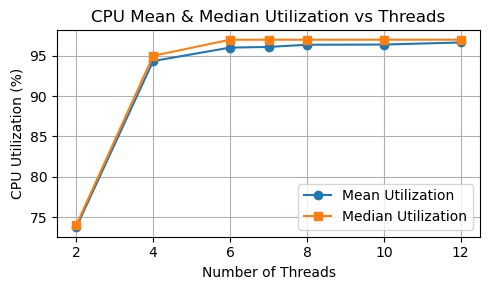

In [15]:
plt.figure(figsize=(5,3))
plt.plot(all_summaries["threads"], all_summaries["mean"],
         marker="o", label="Mean Utilization")
plt.plot(all_summaries["threads"], all_summaries["median"],
         marker="s", label="Median Utilization")
plt.xlabel("Number of Threads")
plt.ylabel("CPU Utilization (%)")
plt.title("CPU Mean & Median Utilization vs Threads")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Throughput and Latency analysis

In [16]:
import re
import pandas as pd
import matplotlib.pyplot as plt

def parse_experiment_results(filename):
    pattern_threads = re.compile(r"Number of threads:\s*(\d+)")
    pattern_requests_made = re.compile(r"Total requests made:\s*(\d+)")
    pattern_requests_completed = re.compile(r"Total requests completed:\s*(\d+)")
    pattern_throughput = re.compile(r"Throughput:\s*([\d.]+)\s*req/sec")
    pattern_latency = re.compile(r"Avg response time:\s*([\d.]+)\s*ms")

    data = {
        "threads": [],
        "throughput": [],
        "avg_latency_ms": [],
        "requests_made":[],
        "requests_completed":[]
    }

    with open(filename, 'r') as f:
        for line in f:
            # extract threads
            m = pattern_threads.search(line)
            if m:
                data["threads"].append(int(m.group(1)))
                continue

            # extract throughput
            m = pattern_throughput.search(line)
            if m:
                data["throughput"].append(float(m.group(1)))
                continue

            # extract latency
            m = pattern_latency.search(line)
            if m:
                data["avg_latency_ms"].append(float(m.group(1)))
                continue
            
            # extract requests_made
            m = pattern_requests_made.search(line)
            if m:
                data["requests_made"].append(int(m.group(1)))
                continue
            
            # extract requests_completed
            m = pattern_requests_completed.search(line)
            if m:
                data["requests_completed"].append(int(m.group(1)))
                continue
            

    df = pd.DataFrame(data)
    return df


def plot_results(df):
    
    # Plot throughput
    plt.figure(figsize=(5,3))
    plt.plot(df["threads"], df["throughput"], marker="o")
    plt.xlabel("Number of Threads")
    plt.ylabel("Throughput (req/sec)")
    plt.title("Threads vs Throughput")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plot latency
    plt.figure(figsize=(5,3))
    plt.plot(df["threads"], df["avg_latency_ms"], marker="o")
    plt.xlabel("Number of Threads")
    plt.ylabel("Average Latency (ms)")
    plt.title("Threads vs Avg Latency")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


   threads  throughput  avg_latency_ms  requests_made  requests_completed
0        2     1266.47         1.57867         455931              455931
1        4     1456.85         2.74508         524467              524467
2        6     1473.69         4.07088         530528              530528
3        7     1492.40         4.68988         537265              537265
4        8     1517.77         5.27037         546397              546397
5       10     1510.71         6.61890         543854              543854
6       12     1512.30         7.86170         544428              544428


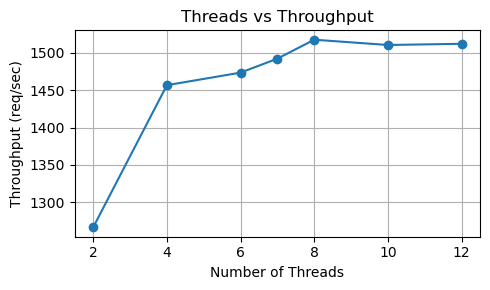

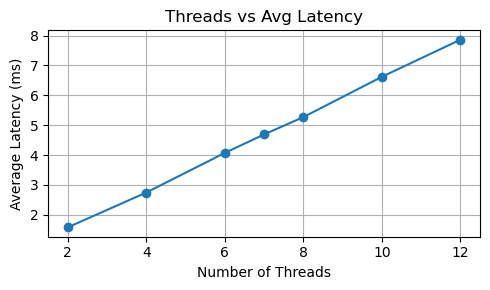

In [18]:
df = parse_experiment_results("./GET take2")
print(df)
plot_results(df)